In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, a=1., b=1.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0
    r_c = np.hypot((x_2d - x_c) / a, (y_2d - y_c) / b)
    
    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()

In [3]:
def moca2(nic, njc, r, u, v, X, Y):
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
    xx = x1 - X.T[nic, njc]

    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
    yy = y2 - Y.T[nic, njc]

    def lin_fit(x, y):
        p = np.polyfit(x, y, 1)
        y_pred = np.polyval(p, x)
        ss_tot, ss_res = np.sum((y - np.mean(y))**2), np.sum((y - y_pred)**2)
        r2 = 1.0 if ss_tot == 0 else 1 - ss_res / ss_tot
        return p[0], p[1], r2

    A1, A0, r2A = lin_fit(xx, u1)
    B1, B0, r2B = lin_fit(xx, v1)
    C1, C0, r2C = lin_fit(yy, u2)
    D1, D0, r2D = lin_fit(yy, v2)

    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2

    x0 = - ( alpha*gamma + beta*C1  ) / (C1*B1+gamma**2)
    y0 = ( beta*gamma-alpha*B1  ) / (C1*B1+gamma**2)
    w = 2 * (q11 + q22)

    return x0 + X.T[nic, njc], y0 + Y.T[nic, njc], w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy
    

In [4]:
X, Y = np.meshgrid(x, y)
nic, njc = 55, 55
r = 7

df_tests = pd.DataFrame({
    'nic': [nic, 40, 30, nic, nic, nic],
    'njc': [njc, 60, 30, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel = moca2(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name
    }

-9.340174345633478 -9.340174345633478
1647.4959207934905 -1647.4959207934908
-133.9301144365494 -133.9301144365494


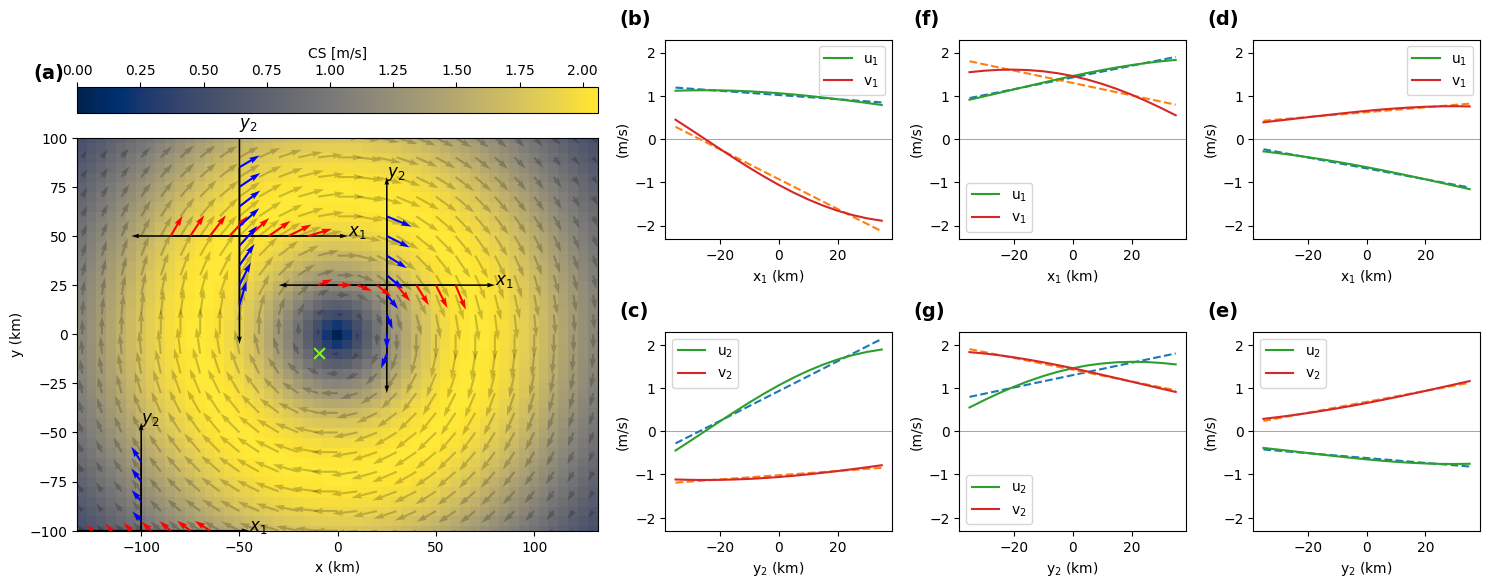

In [14]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$', fontsize=12)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$', fontsize=12)
        
        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r')
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='b')
        ax_main.scatter(x0, y0, color='lawngreen', marker='x', s=60)
        print(x0, y0)
        
ax_main.text(-155, 130, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
        
        p_u1 = np.polyfit(xx, u1, 1)
        p_v1 = np.polyfit(xx, v1, 1)
        ax2.plot(xx, np.polyval(p_u1, xx), '--')
        ax2.plot(xx, np.polyval(p_v1, xx), '--')
        ax2.plot(xx, u1, label=r'u$_1$')
        ax2.plot(xx, v1, label=r'v$_1$')
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend()
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
        
        p_u2 = np.polyfit(yy, u2, 1)
        p_v2 = np.polyfit(yy, v2, 1)
        ax3.plot(yy, np.polyval(p_u2, yy), '--')
        ax3.plot(yy, np.polyval(p_v2, yy), '--')
        ax3.plot(yy, u2, label=r'u$_2$')
        ax3.plot(yy, v2, label=r'v$_2$')
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend()
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

        axs.extend([ax2, ax3])
        j += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()